In [1]:
import os
import cv2
import glob
import joblib
import numpy as np
from pathlib import Path

from PIL import Image, ImageDraw, ImageFont
from skimage import feature
from skimage.segmentation import mark_boundaries
from skimage.feature import hog, local_binary_pattern

import shap
from lime import lime_image
from lime.lime_tabular import LimeTabularExplainer

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# importing malaria dataset class to map bounding boxes on one image
# and skipping any null values with detection collate
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from malaria_dataset import MalariaDataset, detection_collate

c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_path = os.path.join('..', 'dataset', 'malaria')
train_base_path = os.path.join(root_path, 'training_ds')
test_base_path = os.path.join(root_path, 'testing_ds')
image_path = os.path.join(root_path, 'images')
train_json_path = os.path.join(root_path, 'training.json')
test_json_path = os.path.join(root_path, 'test.json')

FEATURES_DIR = os.path.join(root_path, 'extracted_features')
os.makedirs(FEATURES_DIR, exist_ok=True)

MODELS_DIR = os.path.join('.', 'trained_models')
os.makedirs(MODELS_DIR, exist_ok=True)


image_sizes = [128]
print("Root Path:", root_path)
print("Train Base Path:", train_base_path)
print("Test Base Path:", test_base_path)

Root Path: ..\dataset\malaria
Train Base Path: ..\dataset\malaria\training_ds
Test Base Path: ..\dataset\malaria\testing_ds


## Analysis

In [ ]:
print("\n\n--- STARTING: COMPARING ALL TRAINED MODELS ---")

#  Configuration 
KNOWN_POSITIVE_CELL_IMAGE = r"C:\Users\shera\Desktop\fyp\fyp\dataset\malaria\extracted_images_by_classes\leukocyte\ef815e3a-02a6-4cf8-9262-45bc74c50b00_cell_17_leukocyte.png"

CLASS_MAP = {
    0: 'difficult', 1: 'gametocyte', 2: 'leukocyte', 3: 'red blood cell',
    4: 'ring', 5: 'schizont', 6: 'trophozoite'
}

# Feature Extraction Functions For Testing Images
def extract_hog_features(image_patch):
    gray_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2GRAY)
    return hog(gray_patch, orientations=9, pixels_per_cell=(8, 8),
               cells_per_block=(2, 2), block_norm='L2-Hys', transform_sqrt=True)

def extract_hist_features(image_patch):
    hist = cv2.calcHist([image_patch], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(image_patch):
    gray_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_patch, n_points, radius, 'uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist


### Predicting Class 



--- STARTING: COMPARING ALL TRAINED MODELS ---

--- Testing Model: 128_HIST_rf_model.pkl ---
Ground Truth: 'leukocyte'
Prediction: 'red blood cell' (93.00%)


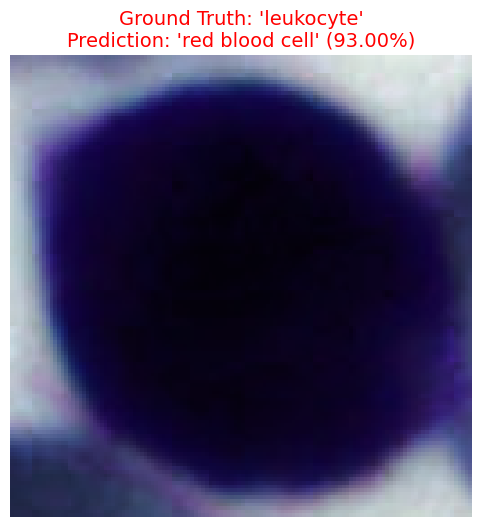


--- Testing Model: 128_HOG_rf_model.pkl ---
NOTE: HOG model detected. Resizing image to 64x64 to match training conditions.
Ground Truth: 'leukocyte'
Prediction: 'red blood cell' (73.00%)


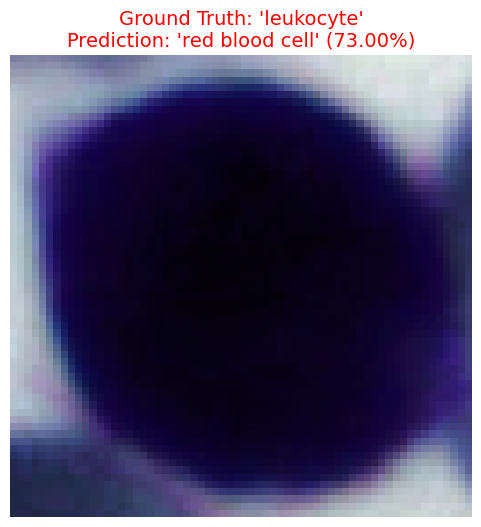


--- Testing Model: 128_LBP_rf_model.pkl ---
Ground Truth: 'leukocyte'
Prediction: 'red blood cell' (53.00%)


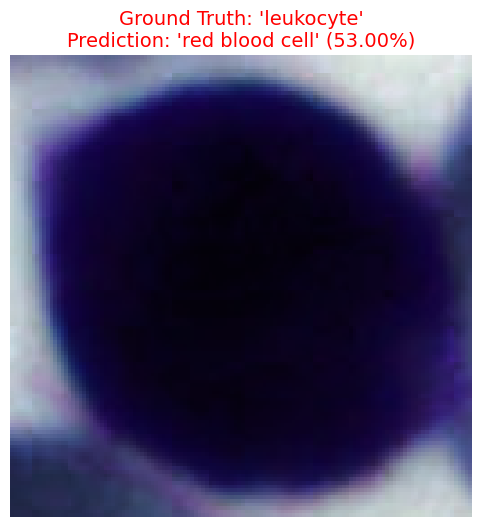

In [ ]:
# Classify images with all the models
def classify_with_model(image_path, pipeline_path, class_map):
    """Loads a pipeline and classifies a single cell image, auto-detecting the feature type."""
    
    try:
        pipeline = joblib.load(pipeline_path)
        filename = os.path.basename(pipeline_path)
        size_str, extractor_name, _ = filename.split('_', 2)
        image_size = int(size_str)
    except Exception as e:
        print(f"\nError loading or parsing '{pipeline_path}': {e}")
        return

    print(f"\n--- Testing Model: {filename} ---")
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read the image at '{image_path}'.")
        return
        
    if extractor_name == 'HOG':
        print("NOTE: HOG model detected. Resizing image to 64x64 to match training conditions.")
        final_image_size = 64
    else:
        final_image_size = image_size
        
    resized_image = cv2.resize(image, (final_image_size, final_image_size))
    
    if extractor_name == 'HOG':
        features = extract_hog_features(resized_image).reshape(1, -1)
    elif extractor_name == 'HIST':
        features = extract_hist_features(resized_image).reshape(1, -1)
    elif extractor_name == 'LBP':
        features = extract_lbp_features(resized_image).reshape(1, -1)
    else:
        print(f"Error: Unknown feature extractor '{extractor_name}' in filename.")
        return

    try:
        prediction_idx = pipeline.predict(features)[0]
        prediction_proba = pipeline.predict_proba(features)[0]
    except ValueError as e:
        print(f"Prediction failed. This is likely a feature mismatch error.")
        print(f"Details: {e}")
        return
    
    predicted_class_name = class_map.get(prediction_idx, "Unknown")
    confidence = prediction_proba[prediction_idx] * 100

    ground_truth_name = os.path.basename(image_path).split('_')[-1].split('.')[0]
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    
    title_text = (
        f"Ground Truth: '{ground_truth_name}'\n"
        f"Prediction: '{predicted_class_name}' ({confidence:.2f}%)"
    )
    title_color = "green" if predicted_class_name == ground_truth_name else "red"
    
    plt.title(title_text, color=title_color, fontsize=14)
    print(title_text)
    plt.axis('off')
    plt.show()

# --- Find all model files and run the comparison ---
model_files = glob.glob(os.path.join(MODELS_DIR, "*.pkl"))

if not model_files:
    print(f"ERROR: No model (.pkl) files found in the directory: {MODELS_DIR}")
else:
    for model_path in model_files:
        classify_with_model(KNOWN_POSITIVE_CELL_IMAGE, model_path, CLASS_MAP)

In [ ]:
feature_files = glob.glob(os.path.join(FEATURES_DIR, "*.pkl"))

# Getting the models
for file_path in feature_files:
    filename = os.path.basename(file_path)
    size, extractor_name, _ = filename.split('_', 2)
    
    print(f"\n{'='*25}")
    print(f"RUNNING EXPERIMENT")
    print(f"Image Size: {size}x{size} | Feature Extractor: {extractor_name}")
    print(f"{'='*25}")
    
    data = joblib.load(file_path)
    X_train, y_train = data['X_train'], data['y_train']
    X_test, y_test = data['X_test'], data['y_test']
    le = data['label_encoder']
    
    model_path = os.path.join(MODELS_DIR, f"{size}_{extractor_name}_rf_model.pkl")

    if os.path.exists(model_path):
        print(f"Loading pre-trained model from: {model_path}")
        pipeline = joblib.load(model_path)
    else:
        print("Pre-trained model not found. Training a new model...")

        # --- START OF CORRECTION ---
        # 1. Count the number of samples in each class in the training data
        target_stats = Counter(y_train)
        print("Original training set class distribution:", target_stats)

        # 2. Define our "smart" sampling strategy
        # We will boost any class with fewer than 1000 samples up to 1000.
        # Classes with more than 1000 samples will be left as they are.
        sampling_strategy_dict = {}
        floor_samples = 1000 
        for class_index, num_samples in target_stats.items():
            if num_samples < floor_samples:
                sampling_strategy_dict[class_index] = floor_samples
            else:
                sampling_strategy_dict[class_index] = num_samples

        print("New SMOTE sampling strategy:", sampling_strategy_dict)

        # 3. Create the SMOTE object with our new dictionary strategy
        smote_with_dict = SMOTE(random_state=42, sampling_strategy=sampling_strategy_dict)
        
        # 4. Use the new SMOTE object in the pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('smote', smote_with_dict), # Use the new dictionary-based SMOTE
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
        ])


RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: HIST
Loading pre-trained model from: .\trained_models\128_HIST_rf_model.pkl

RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: HOG
Loading pre-trained model from: .\trained_models\128_HOG_rf_model.pkl

RUNNING EXPERIMENT
Image Size: 128x128 | Feature Extractor: LBP
Loading pre-trained model from: .\trained_models\128_LBP_rf_model.pkl


In [7]:
FEATURE_TYPE = "HOG"   # or "LBP" or "HIST"

# Feature & class names (best effort defaults)
n_features = X_train.shape[1]
prefix = {"HOG":"hog", "LBP":"lbp", "HIST":"hist"}.get(FEATURE_TYPE, "f")
feature_names = [f"{prefix}_{i}" for i in range(n_features)]

if hasattr(pipeline, "classes_"):
    class_names = [str(c) for c in pipeline.classes_]
elif "CLASS_MAP" in globals():
    class_names = [CLASS_MAP[i] for i in sorted(CLASS_MAP.keys())]
elif "class_map" in globals():
    class_names = [class_map[i] for i in sorted(class_map.keys())]
else:
    class_names = None  # LIME can still run without names


### Implememting LIME & SHAP


LIME top features (feature -> weight):
[('hog_21 > 0.01', -0.09039087276929385), ('hog_19 > 0.01', -0.046002139329389), ('hog_23 <= 0.01', -0.04485656379197222), ('0.02 < hog_24 <= 0.02', 0.033401202462264586), ('hog_18 > 0.01', -0.028699287784318427), ('hog_11 > 0.06', 0.02239992946630345), ('0.01 < hog_20 <= 0.01', 0.020644216273219836), ('hog_17 > 0.02', -0.02026672397428038), ('hog_12 > 0.09', 0.019990642930434413), ('hog_25 <= 0.37', -0.010581494366481864), ('0.01 < hog_16 <= 0.02', -0.008474971539139148), ('0.02 < hog_10 <= 0.03', -0.008394679069645734)]


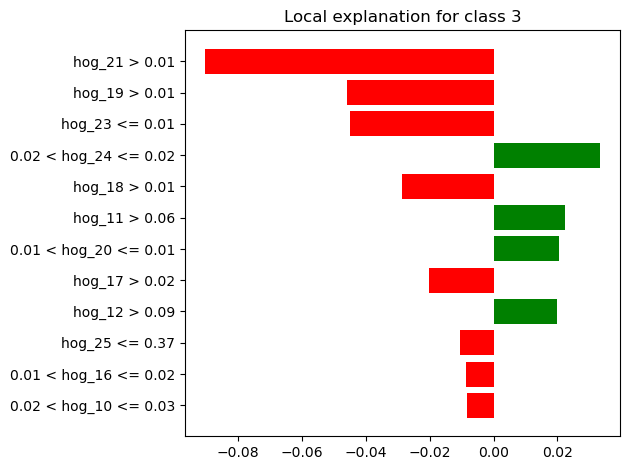


Predicted: 3
  P(0) = 0.020
  P(1) = 0.000
  P(2) = 0.280
  P(3) = 0.660
  P(4) = 0.000
  P(5) = 0.010
  P(6) = 0.030


In [8]:

# Build the explainer on training features
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True,
    sample_around_instance=True,
    random_state=42
)

# Pick an index in X_test to explain
i = 0

# Get the LIME explanation for that row
exp = lime_explainer.explain_instance(
    data_row=np.array(X_test[i]),
    predict_fn=pipeline.predict_proba, 
    num_features=12,
    top_labels=1
)

# Show as list and plot
print("\nLIME top features (feature -> weight):")
print(exp.as_list(label=exp.top_labels[0]))

fig = exp.as_pyplot_figure(label=exp.top_labels[0])
plt.tight_layout()
plt.show()

# (Optional) Also see the actual prediction vs. probabilities
proba = pipeline.predict_proba([X_test[i]])[0]
pred_idx = int(np.argmax(proba))
print(f"\nPredicted: {class_names[pred_idx] if class_names else pred_idx}")
for k, p in enumerate(proba):
    name = class_names[k] if class_names else k
    print(f"  P({name}) = {p:.3f}")


PermutationExplainer explainer: 51it [00:34,  1.45it/s]                        


Showing beeswarm plot for class: 'ring' (index 4)


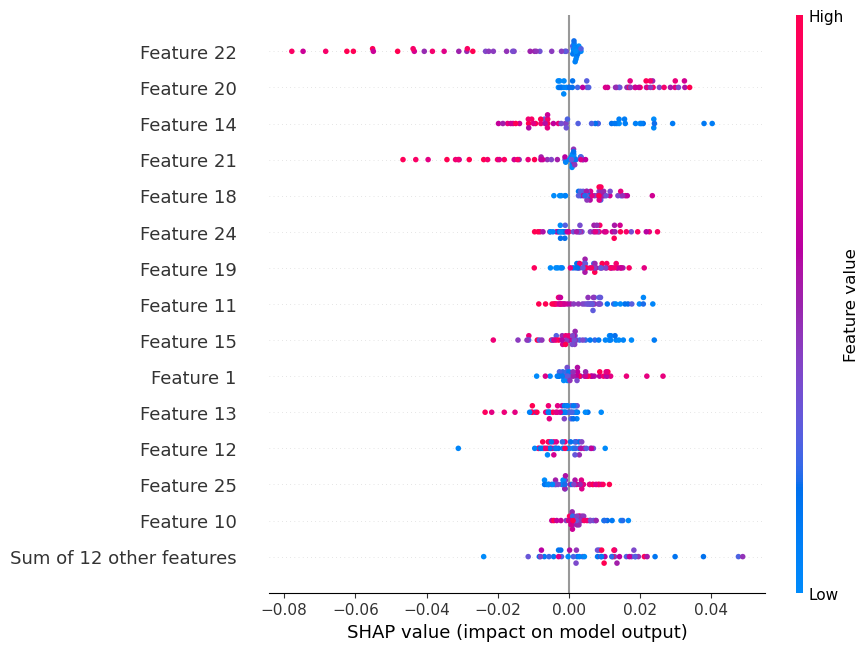


Showing waterfall plot for sample 0, which was predicted as class: 'red_blood_cell'


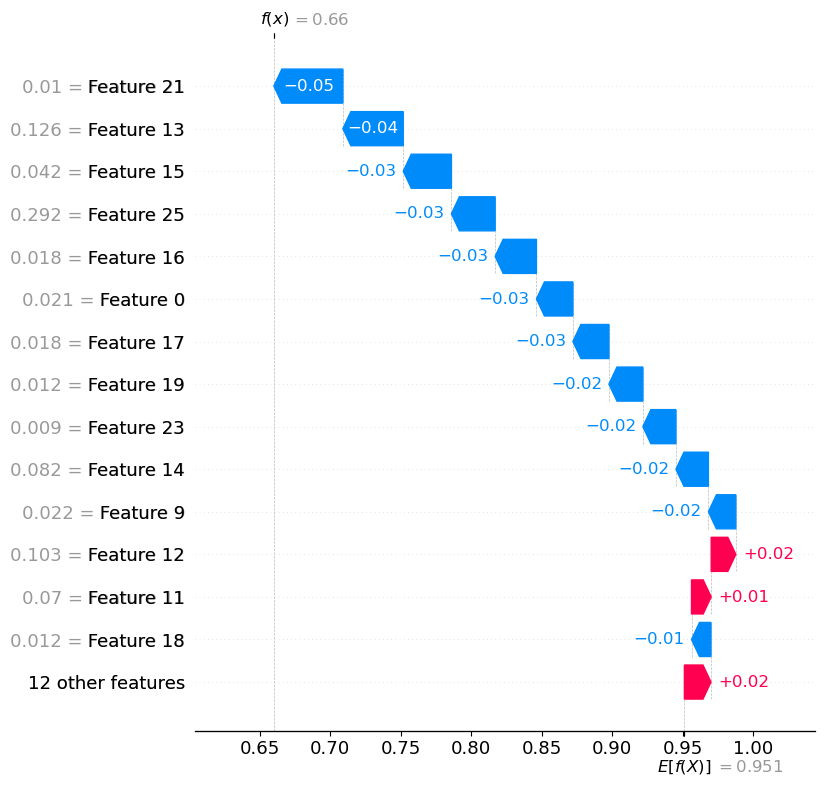

In [9]:

# A small, representative background sample keeps it fast
bg_size = min(200, X_train.shape[0])
X_bg = shap.sample(np.array(X_train), bg_size, random_state=42)

# Model-agnostic explainer over pipeline.predict_proba
f = lambda X: pipeline.predict_proba(np.array(X))
explainer = shap.Explainer(f, shap.maskers.Independent(X_bg))

# Explain a batch so you can draw global plots
batch = X_test[:50] if X_test.shape[0] > 50 else X_test
shap_values = explainer(batch)


# --- THE FIX IS HERE ---
# We need to tell the plot which class to explain.
# Let's choose 'ring' as our target class for the global plot.
# First, define your class map to get the correct index.
CLASS_MAP = {
    'difficult': 0, 'gametocyte': 1, 'leukocyte': 2, 'red blood cell': 3,
    'ring': 4, 'schizont': 5, 'trophozoite': 6
}
# Assuming your LabelEncoder (le) has the same order
class_names = le.classes_ # Or list(CLASS_MAP.keys())
target_class_name = 'ring'
target_class_index = list(class_names).index(target_class_name)

print(f"Showing beeswarm plot for class: '{target_class_name}' (index {target_class_index})")

# Now, slice the shap_values to get the explanations for only the 'ring' class
shap_values_for_class = shap_values[:, :, target_class_index]
# --- END OF FIX ---


# Global view: which features matter overall
# Pass the sliced shap_values to the plot
shap.plots.beeswarm(shap_values_for_class, max_display=15, show=True)


# Local view: why did we predict class c for row i?
# This part of your code was already correct!
i_local = 0
if shap_values.values.ndim == 3:  # (n_samples, n_features, n_classes)
    # Find the class that was actually predicted for this specific sample
    c = int(np.argmax(f([batch[i_local]])[0]))
    print(f"\nShowing waterfall plot for sample {i_local}, which was predicted as class: '{class_names[c]}'")
    shap.plots.waterfall(shap_values[i_local, :, c], max_display=15, show=True)
else:  # binary older shap sometimes returns (n_samples, n_features)
    shap.plots.waterfall(shap_values[i_local], max_display=15, show=True)

C:\Users\shera\AppData\Local\Temp\ipykernel_22676\163003958.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_tree, X_model_batch, feature_names=feature_names, max_display=15, show=True)
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new beha

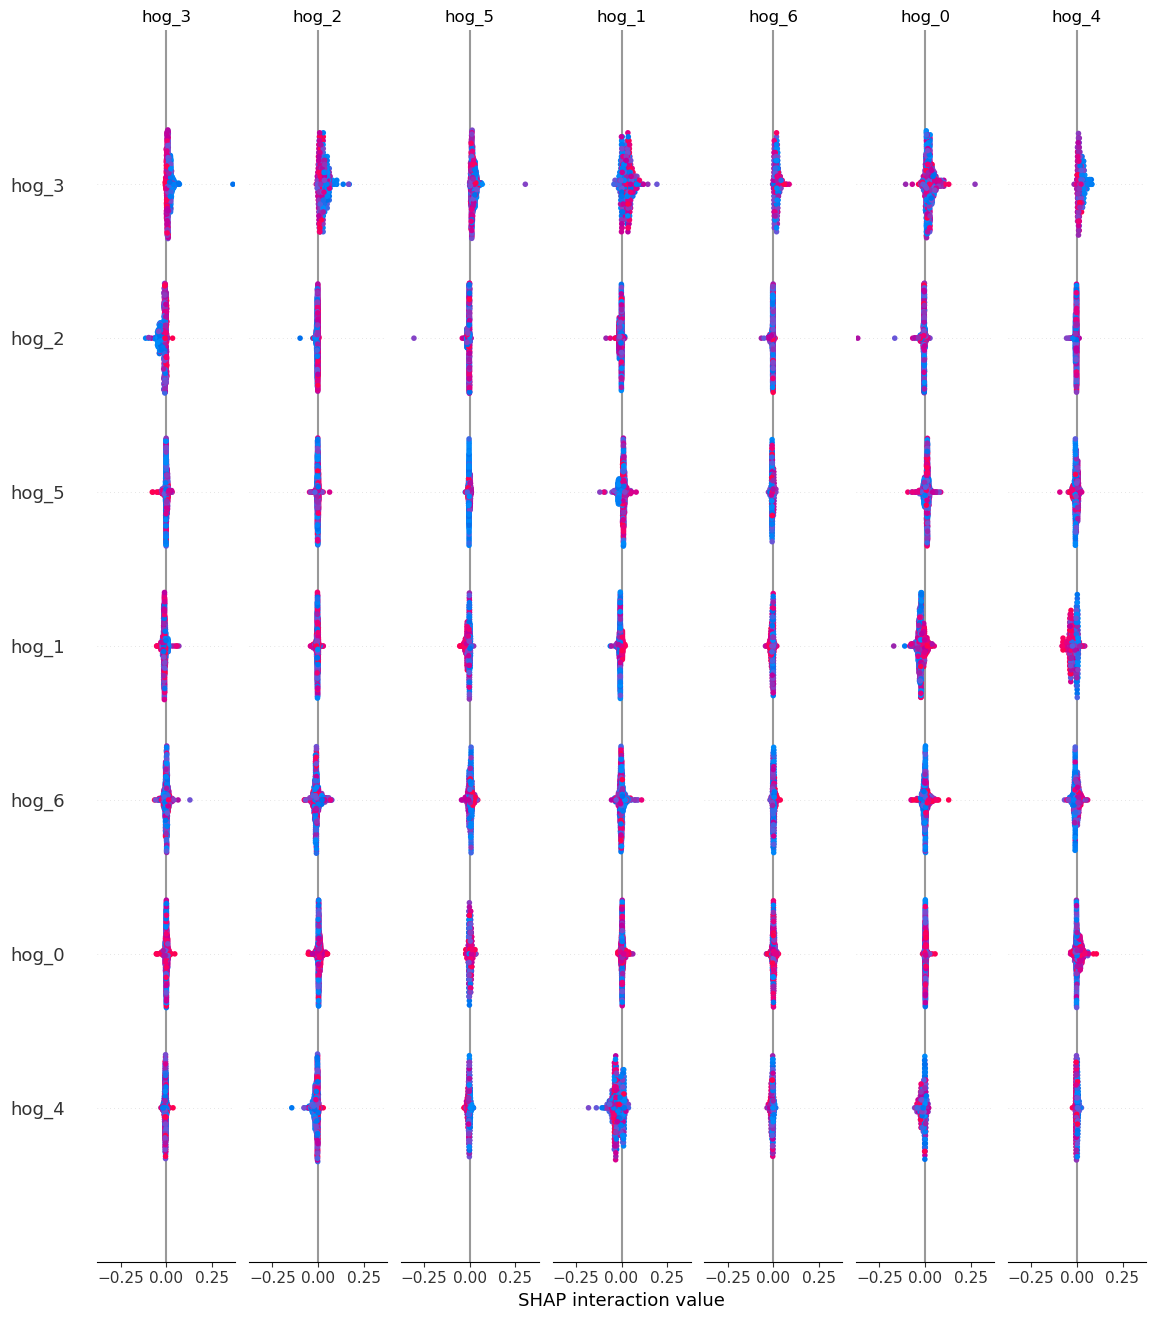

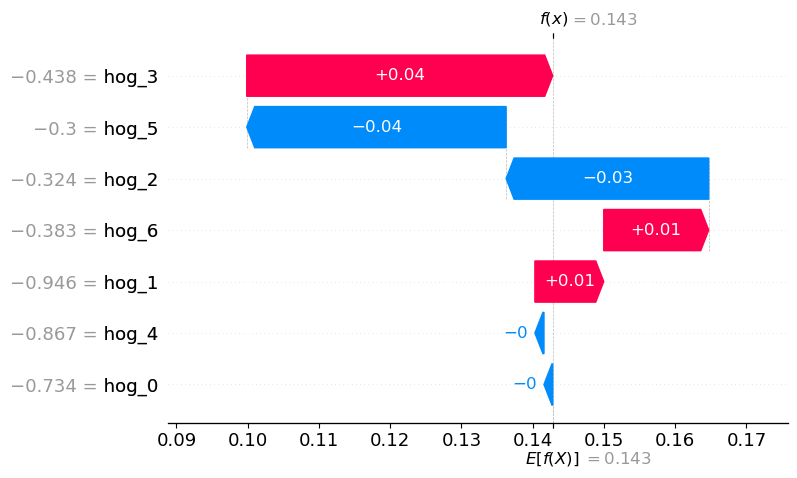

In [10]:
# Grab the fitted final estimator
final_est = pipeline.steps[-1][1]

if isinstance(final_est, RandomForestClassifier):
    # Build a transformer-only pipeline from the *fitted* steps before the classifier
    pre_steps = [(name, step) for name, step in pipeline.steps[:-1] if hasattr(step, "transform")]
    preproc = SkPipeline(pre_steps) if pre_steps else None

    # Transform data with already-fitted preprocessors
    X_model_train = preproc.transform(X_train) if preproc else X_train
    X_model_batch = (preproc.transform(X_test[:500]) if (preproc and X_test.shape[0] > 0) else
                     (X_test[:500] if X_test.shape[0] > 0 else X_test))

    import shap
    tree_explainer = shap.TreeExplainer(final_est, feature_names=feature_names)
    shap_values_tree = tree_explainer.shap_values(X_model_batch)

    # Global importance
    shap.summary_plot(shap_values_tree, X_model_batch, feature_names=feature_names, max_display=15, show=True)

    # Local explanation for the first row & its predicted class
    proba = final_est.predict_proba(X_model_batch[[0]])[0]
    c = int(np.argmax(proba))
    shap.waterfall_plot(shap.Explanation(
        values=shap_values_tree[c][0],
        base_values=tree_explainer.expected_value[c],
        data=X_model_batch[0],
        feature_names=feature_names
    ))


Model pipeline loaded successfully.

Generating LIME explanation... (This may take a moment)


100%|██████████| 1000/1000 [00:05<00:00, 173.38it/s]


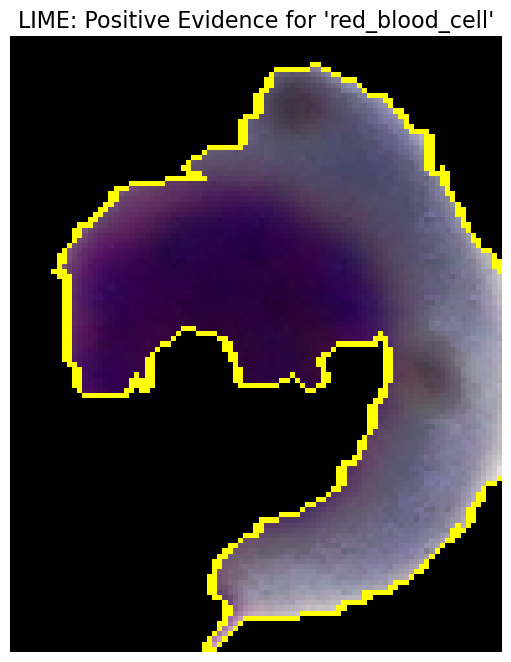

In [11]:
MODEL_PIPELINE_PATH = r'C:\Users\shera\Desktop\fyp\fyp\random_forest_model\trained_models\128_HOG_rf_model.pkl'
IMAGE_TO_EXPLAIN_PATH = r"C:\Users\shera\Desktop\fyp\fyp\dataset\malaria\extracted_images_by_classes\leukocyte\0f735cca-051c-4048-a1fa-cb36f389e12f_cell_53_leukocyte.png"
FEATURE_TYPE = "HOG"

try:
    pipeline = joblib.load(MODEL_PIPELINE_PATH)
    # Assuming the pipeline was saved from a LabelEncoder workflow
    class_names = pipeline.named_steps['rf'].classes_ 
    print("Model pipeline loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    pipeline = None

def extract_hog_features(gray_image):
    """Extracts HOG features from a GRAYSCALE image."""
    return hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
               cells_per_block=(2, 2), block_norm='L2-Hys', transform_sqrt=True)

def extract_hist_features(color_image):
    """Extracts Color Histogram features from a COLOR image."""
    hist = cv2.calcHist([color_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(gray_image):
    """Extracts LBP features from a GRAYSCALE image."""
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_image, n_points, radius, 'uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# --- This function now correctly manages the image format ---
def _extract_features_from_image(img_bgr, feature_type="HOG"):
    """Resizes and passes the correct image format to the feature extractors."""
    
    # --- FIX: The resize dimension must match the model being tested ---
    # The HOG model expects 64x64, the others likely 128x128.
    if feature_type == "HOG":
        img = cv2.resize(img_bgr, (64, 64))
    else:
        img = cv2.resize(img_bgr, (128, 128))

    # Pass the correct image type (grayscale or color) to the right function
    if feature_type == "HOG":
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return extract_hog_features(gray).reshape(1, -1)
    elif feature_type == "LBP":
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return extract_lbp_features(gray).reshape(1, -1)
    elif feature_type == "HIST":
        return extract_hist_features(img).reshape(1, -1) # HIST uses the color image
    else:
        raise ValueError("Unknown feature_type")

def predict_proba_on_raw_images(list_of_rgb_images):
    """The 'adapter' function for LIME."""
    feats = []
    for arr in list_of_rgb_images:
        bgr = cv2.cvtColor(arr.astype(np.uint8), cv2.COLOR_RGB2BGR)
        feats.append(_extract_features_from_image(bgr, FEATURE_TYPE))
    
    Xf = np.vstack(feats)
    return pipeline.predict_proba(Xf)

if pipeline:
    img_bgr = cv2.imread(IMAGE_TO_EXPLAIN_PATH)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    img_explainer = lime_image.LimeImageExplainer()
    
    print("\nGenerating LIME explanation... (This may take a moment)")
    img_exp = img_explainer.explain_instance(
        image=img_rgb,
        classifier_fn=predict_proba_on_raw_images,
        top_labels=1, hide_color=0, num_samples=1000
    )

    label = img_exp.top_labels[0]
    temp, mask = img_exp.get_image_and_mask(
        label=label, positive_only=True, hide_rest=True, min_weight=0.01
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    # Note: LIME may use integer indices, so we need to map them back to names if le.classes_ is available
    predicted_class_name = le.inverse_transform([label])[0] if 'le' in locals() else label
    plt.title(f"LIME: Positive Evidence for '{predicted_class_name}'", fontsize=16)
    plt.axis("off")
    plt.show()

In [1]:
# ==============================================================================
# STEP 1: IMPORTS & CONFIGURATION
# ==============================================================================
import os
import cv2
import glob
import joblib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.feature import hog, local_binary_pattern
from skimage.segmentation import mark_boundaries
from lime import lime_image
import shap

print("--- All libraries imported ---")

# --- Configuration ---
# IMPORTANT: This path is now updated to point to your SVM models directory
MODELS_DIR = r'.\trained_models' #<-- ADJUST THIS PATH IF NEEDED
os.makedirs(MODELS_DIR, exist_ok=True) # Ensure the directory exists

IMAGE_TO_ANALYZE_PATH = r"C:\Users\shera\Desktop\fyp\fyp\dataset\malaria\testing_ds\extracted_by_class\ring\c3631a04-b757-407b-8e7e-1ed3a6c463d4_cell_32_ring.png"

CLASS_MAP = {
    0: 'difficult', 1: 'gametocyte', 2: 'leukocyte', 3: 'red blood cell',
    4: 'ring', 5: 'schizont', 6: 'trophozoite'
}
CLASS_NAMES = [name for idx, name in sorted(CLASS_MAP.items(), key=lambda item: item[1])]

# ==============================================================================
# STEP 2: DEFINE FEATURE EXTRACTION FUNCTIONS
# ==============================================================================
def extract_hog_features(image_patch):
    """Extracts HOG features from a BGR image patch."""
    gray_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2GRAY)
    return hog(gray_patch, orientations=9, pixels_per_cell=(8, 8),
               cells_per_block=(2, 2), block_norm='L2-Hys', transform_sqrt=True)

def extract_hist_features(image_patch):
    """Extracts Color Histogram features from a BGR image patch."""
    hist = cv2.calcHist([image_patch], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(image_patch):
    """Extracts LBP features from a BGR image patch."""
    gray_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2GRAY)
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(gray_patch, n_points, radius, 'uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# A dictionary to easily call the correct function
FEATURE_EXTRACTOR_FNS = {
    'HOG': extract_hog_features,
    'HIST': extract_hist_features,
    'LBP': extract_lbp_features
}

# ==============================================================================
# STEP 3: MAIN ANALYSIS LOOP FOR SVM MODELS
# ==============================================================================
# Find all .pkl model files in the specified directory
model_paths = glob.glob(os.path.join(MODELS_DIR, "*.pkl"))

if not model_paths:
    print(f"ERROR: No SVM model (.pkl) files found in the directory: {MODELS_DIR}")
else:
    print(f"Found {len(model_paths)} SVM models to analyze.")

# Loop through each model and run the full analysis
for model_path in model_paths:
    try:
        # --- Load Model and Get its Info ---
        pipeline = joblib.load(model_path)
        filename = os.path.basename(model_path)
        # Assumes filename format like "128_HOG_model.pkl"
        size_str, feature_type, _ = filename.split('_', 2)
        
        print(f"\n{'='*60}")
        print(f"ANALYZING SVM MODEL: {filename}")
        print(f"{'='*60}")

        # Override image size for the HOG model which was trained on 64x64
        image_size = 64 if feature_type == 'HOG' else int(size_str)
        if feature_type == 'HOG':
            print("NOTE: HOG model detected. Using required image size of 64x64.")

        # --- Load and Prepare Image ---
        image_bgr = cv2.imread(IMAGE_TO_ANALYZE_PATH)
        if image_bgr is None:
            print(f"Could not load image: {IMAGE_TO_ANALYZE_PATH}")
            continue
        
        # --- LIME EXPLANATION ---
        print("\n--- Generating LIME Explanation for SVM ---")
        
        def predict_proba_for_lime(list_of_rgb_images):
            feats = []
            for arr in list_of_rgb_images:
                bgr_image = cv2.cvtColor(arr.astype(np.uint8), cv2.COLOR_RGB2BGR)
                resized_image = cv2.resize(bgr_image, (image_size, image_size))
                feats.append(FEATURE_EXTRACTOR_FNS[feature_type](resized_image))
            return pipeline.predict_proba(np.vstack(feats))

        img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        lime_explainer = lime_image.LimeImageExplainer()
        lime_exp = lime_explainer.explain_instance(
            image=img_rgb, classifier_fn=predict_proba_for_lime,
            top_labels=1, hide_color=0, num_samples=1000
        )
        label = lime_exp.top_labels[0]
        temp, mask = lime_exp.get_image_and_mask(
            label=label, positive_only=True, hide_rest=True, min_weight=0.01
        )
        plt.figure(figsize=(8, 8))
        plt.imshow(mark_boundaries(temp / 255.0, mask))
        plt.title(f"LIME for {filename}\nPositive Evidence for '{CLASS_NAMES[label]}'", fontsize=14)
        plt.axis("off")
        plt.show()

        # --- SHAP EXPLANATION ---
        print("\n--- Generating SHAP Explanation for SVM ---")
        resized_for_shap = cv2.resize(image_bgr, (image_size, image_size))
        X_test_single = FEATURE_EXTRACTOR_FNS[feature_type](resized_for_shap).reshape(1, -1)
        
        # For KernelExplainer, a background dataset is crucial
        # We'll create a dummy one for speed, but for real analysis, a sample of your training data is best
        X_background = np.zeros((1, X_test_single.shape[1]))
        
        shap_explainer = shap.KernelExplainer(pipeline.predict_proba, X_background)
        shap_values = shap_explainer.shap_values(X_test_single, nsamples=100)
        
        prediction_index = pipeline.predict(X_test_single)[0]
        
        # Create a SHAP Explanation object for plotting
        shap_explanation = shap.Explanation(
            values=shap_values[prediction_index][0],
            base_values=shap_explainer.expected_value[prediction_index],
            data=X_test_single[0],
            feature_names=[f"feature_{i}" for i in range(X_test_single.shape[1])]
        )

        plt.title(f"SHAP for {filename}")
        shap.plots.waterfall(shap_explanation, max_display=15, show=True)

    except Exception as e:
        print(f"\n--- FAILED TO ANALYZE MODEL: {model_path} ---")
        print(f"Error: {e}")
        continue

c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- All libraries imported ---
Found 3 SVM models to analyze.

ANALYZING SVM MODEL: 128_HIST_model.pkl

--- Generating LIME Explanation for SVM ---


  1%|          | 9/1000 [00:00<00:01, 735.21it/s]



--- FAILED TO ANALYZE MODEL: .\trained_models\128_HIST_model.pkl ---
Error: This 'Pipeline' has no attribute 'predict_proba'

ANALYZING SVM MODEL: 128_HOG_model.pkl
NOTE: HOG model detected. Using required image size of 64x64.

--- Generating LIME Explanation for SVM ---


  1%|          | 9/1000 [00:00<00:03, 251.67it/s]



--- FAILED TO ANALYZE MODEL: .\trained_models\128_HOG_model.pkl ---
Error: This 'Pipeline' has no attribute 'predict_proba'

ANALYZING SVM MODEL: 128_LBP_model.pkl

--- Generating LIME Explanation for SVM ---


  1%|          | 9/1000 [00:00<00:14, 69.83it/s]


--- FAILED TO ANALYZE MODEL: .\trained_models\128_LBP_model.pkl ---
Error: This 'Pipeline' has no attribute 'predict_proba'


In [ ]:
# SCRIPT 1: RE-TRAIN SVM MODELS WITH PROBABILITY ENABLED

import os
import glob
import pandas as pd
import joblib
from scipy.sparse import issparse
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# --- Configuration ---
FEATURES_DIR = r'C:\Users\shera\Desktop\fyp\fyp\dataset\malaria\extracted_features2'
MODELS_DIR = r'.\trained_models_svm' #<-- New folder for the corrected SVM models
os.makedirs(MODELS_DIR, exist_ok=True)

experiment_results = []
feature_files = glob.glob(os.path.join(FEATURES_DIR, "*.pkl"))

if not feature_files:
    print(f"ERROR: No feature files found in: {FEATURES_DIR}")
else:
    # --- Main Training Loop ---
    for file_path in feature_files:
        filename = os.path.basename(file_path)
        size, extractor_name, _ = filename.split('_', 2)
        
        print(f"\n{'='*25}")
        print(f"TRAINING SVM: {size}x{size} | {extractor_name}")
        print(f"{'='*25}")
        
        data = joblib.load(file_path)
        X_train, y_train = data['X_train'], data['y_train']
        
        # --- THE FIX IS HERE ---
        # The SVC classifier now includes `probability=True`
        pipeline = ImbPipeline(steps=[
            ('scaler', StandardScaler(with_mean=not issparse(X_train))),
            ('smote', SMOTE(random_state=42)),
            ('svm', SVC(kernel='rbf', C=10, gamma=0.01,
                        class_weight='balanced',
                        random_state=42,
                        probability=True)) # <-- THIS LINE IS THE FIX
        ])

        print("Training new model...")
        pipeline.fit(X_train, y_train)

        model_path = os.path.join(MODELS_DIR, f"{size}_{extractor_name}_model.pkl")
        print(f"Saving trained model to: {model_path}")
        joblib.dump(pipeline, model_path)

print("\n✅ All SVM models have been re-trained successfully with probability enabled.")


TRAINING SVM: 128x128 | HIST
Training new model...


In [ ]:
# SCRIPT 2: THE CORRECTED SVM ANALYSIS SCRIPT

import os
import cv2
import glob
import joblib
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from skimage.feature import hog, local_binary_pattern
from skimage.segmentation import mark_boundaries
from lime import lime_image
import shap

# --- Configuration ---
MODELS_DIR = r'.\trained_models_svm' #<-- Point to the new SVM models
IMAGE_TO_ANALYZE_PATH = r"C:\Users\shera\Desktop\fyp\fyp\dataset\malaria\testing_ds\extracted_by_class\ring\c3631a04-b757-407b-8e7e-1ed3a6c463d4_cell_32_ring.png"
CLASS_NAMES = ['difficult', 'gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite']

# --- (Feature extraction functions remain the same) ---
# ... (include the extract_hog_features, etc., functions here) ...

# --- Main Analysis Loop ---
model_paths = glob.glob(os.path.join(MODELS_DIR, "*.pkl"))

if not model_paths:
    print(f"ERROR: No SVM models found in: {MODELS_DIR}")
else:
    for model_path in model_paths:
        try:
            pipeline = joblib.load(model_path)
            # ... (the rest of your analysis loop code for LIME and SHAP) ...
            
            # --- SHAP EXPLANATION (CORRECTED FOR SVM) ---
            print("\n--- Generating SHAP Explanation for SVM ---")
            
            # For KernelExplainer, we need a small, representative background dataset
            X_train, _, _, _ = data['X_train'], data['y_train'], data['X_test'], data['y_test'] # You'll need to load the data again for this
            X_background = shap.sample(X_train, 50) # Sample 50 points for the background
            
            # Use KernelExplainer for SVMs
            shap_explainer = shap.KernelExplainer(pipeline.predict_proba, X_background)
            
            # Prepare the single image for prediction
            resized_for_shap = cv2.resize(image_bgr, (image_size, image_size))
            X_test_single = FEATURE_EXTRACTOR_FNS[feature_type](resized_for_shap).reshape(1, -1)

            shap_values = shap_explainer.shap_values(X_test_single)
            
            prediction_index = pipeline.predict(X_test_single)[0]

            # Create an Explanation object for the waterfall plot
            shap_explanation = shap.Explanation(
                values=shap_values[prediction_index][0],
                base_values=shap_explainer.expected_value[prediction_index],
                data=X_test_single[0],
                feature_names=[f"feature_{i}" for i in range(X_test_single.shape[1])]
            )

            plt.title(f"SHAP for {filename}")
            shap.plots.waterfall(shap_explanation, max_display=15, show=True)

        except Exception as e:
            print(f"\n--- FAILED TO ANALYZE MODEL: {model_path} ---")
            print(f"Error: {e}")
            continue